The task was to predict the average temperature of the following days:
 26th of october
 1st of november
 29th of november
if i hand this in on the 25th then this means I only have the 24th day after I checked so i need
 +2
 +8
 +36
 days prediction
 
 The first part of this homework is creating the database, this can be skipped if it is downloaded from the link specified below. There are two separate solutions in this notebook which can be ran on their own: and LSTM and a 1D CNN.

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime


# Creating the database with BeautifulSoup
This part was already ran and the database uploaded to this link:
Running this again will regenerate the data base adding the current day as the last one.
This means if it's ran after the 25th of October the predictions at the end will be shifted.
LINK TO DB: https://drive.google.com/open?id=1FaAjor-us4_zK2RTHc0zC7Byt23ZPdmc


In [19]:
# here I use the http://idojarasbudapest.hu/archivalt-idojaras to scrape data from it. For this I send it the
# form for all months for the past years and then scrape what appears in the table of the donwloaded page.
# To get data in the table of the page, a form data needs to be sent to specify the month and year we want the daily
# temperature data from.

# appends a month's data to data_list 
def appendMonthData(year, month,data_list):
    form_data = {
        'ev': year,
        'ho': month
    }
  
    url = "http://idojarasbudapest.hu/archivalt-idojaras"
    response = requests.post(url, data=form_data)
    doc = BeautifulSoup(response.text, 'html.parser')
    
    rows = doc.findAll('table')[0].findAll('tr')
   
    for row in rows[1:]:
        entry_list = []
        cols = row.find_all('td')

        # The timestamp need to be processed separately because in the original
        # table it is separated from the name of the day by a break.
        date = str(cols[0]).split('<br/>')[0]
        date = date[4:].strip()
        date = date.replace('.','-')
        datetime_object = datetime.strptime(date, '%Y-%m-%d')
        # here I exlude the last table row element because only the last year contains numerical
        # data for percipitation, the rest are just marked by general words
        cols = [ele.text.strip() for ele in cols[1:-1]] 
        
        #print("col: " + str(cols))
        entry_list = [ele for ele in cols if ele]
        entry_list.append(datetime_object)
        #print(entry_list) #columns now are: [T_max, T_min, Wind, Timestamp]
        data_list.append(entry_list) # Get rid of empty values


years = list(range(2012,2019))
months = ['01','02','03','04','05','06','07','08','09','10','11','12'] #01 means january 12 is december
#years = [2018]
#months = ['01','02']
# Parsing 2018 we have to be careful to only request data up until the 10th month.
print("years included")
print(years)
data_list=[]
for year in years:
    for month in months:
        ## skip data from the future
        if (year == 2018) and ((month == '11') or (month =='12')):
            break
        appendMonthData(year, month, data_list)
#print(data_list)
# now this data_list can be converted into csv format and write it to a file ('temperature.csv':
with open('temperature.csv', mode='w') as csv_file:
    fieldnames = ['t_avg', 't_max', 't_min', 'wind','timestamp']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data_entry in data_list:
        # calculate the average temperature and also add it as a new column to our existing ones
        t_avg = (float(data_entry[0]) + float(data_entry[1])) / 2
        writer.writerow({'t_avg': t_avg, 't_max': data_entry[0], 't_min': data_entry[1], 'wind': data_entry[2],
                            'timestamp':data_entry[3]})

years included
[2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn import preprocessing
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('temperature.csv',parse_dates=[4])
print(df.shape) # This shows that the database contain 2480 lines of data
df.head()

(2484, 5)


,t_avg,t_max,t_min,wind,timestamp
0,1.0,3.0,-1.0,2.8,2012-01-01
1,2.0,4.0,0.0,4.4,2012-01-02
2,3.5,6.0,1.0,3.9,2012-01-03
3,3.5,6.0,1.0,5.8,2012-01-04
4,2.0,4.0,0.0,10.0,2012-01-05


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 5 columns):
t_avg        2484 non-null float64
t_max        2484 non-null float64
t_min        2484 non-null float64
wind         2484 non-null float64
timestamp    2484 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 97.1 KB


In [4]:
data_start_date = df['timestamp'].iloc[0]
data_end_date = df['timestamp'].iloc[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))
    

Data ranges from 2012-01-01 00:00:00 to 2018-10-24 00:00:00


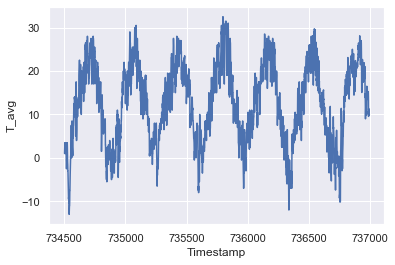

In [5]:
#plot temperature data 
values = df.values
values_timestamp = values[:,4]
#convert dates so it's plottable
values_timestamp = matplotlib.dates.date2num(values_timestamp)
values_t_avg = values[:,0]

def plot_temp(df):
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('T_avg')
    plt.plot(values_timestamp, values_t_avg)
    #plt.plot([1,2,3,4], [1,4,9,16])
    plt.show()
    
plot_temp(df)

# 1d CNN model
This part can be ran on it's own, the previous part is just for gathering the data and analyzing it.

In this part I tried out a convolutional network i found here:  https://gist.github.com/jkleint/1d878d0401b28b281eb75016ed29f2ee#file-timeseries_cnn-py-L113
Turns out this is the same or very similar example we looked at in class so I switched some things to be more in line with what we did in class.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from keras.models import load_model
%matplotlib inline
np.random.seed(0)

import seaborn as sns
sns.set()

df = pd.read_csv('temperature.csv',parse_dates=[4])
print(df.shape) # This shows that the database contain 2480 lines of data
df.head()

C:\Users\Gabor\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(2484, 5)


,t_avg,t_max,t_min,wind,timestamp
0,1.0,3.0,-1.0,2.8,2012-01-01
1,2.0,4.0,0.0,4.4,2012-01-02
2,3.5,6.0,1.0,3.9,2012-01-03
3,3.5,6.0,1.0,5.8,2012-01-04
4,2.0,4.0,0.0,10.0,2012-01-05


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 361, 4)            24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 180, 4)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 176, 4)            84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 88, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 352)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 353       
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None
X shape

C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(365, 1), filters=4, kernel_size=5)`
  after removing the cwd from sys.path.
C:\Users\Gabor\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=4, kernel_size=5)`
  
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted

Train on 993 samples, validate on 497 samples
Epoch 1/50
 - 0s - loss: 227.8232 - mean_absolute_error: 12.7046 - val_loss: 129.1392 - val_mean_absolute_error: 9.1508

Epoch 00001: val_loss improved from inf to 129.13923, saving model to weights_1dcnn_temp.hdf5
Epoch 2/50
 - 0s - loss: 111.8493 - mean_absolute_error: 8.8601 - val_loss: 89.1059 - val_mean_absolute_error: 8.0792

Epoch 00002: val_loss improved from 129.13923 to 89.10589, saving model to weights_1dcnn_temp.hdf5
Epoch 3/50
 - 0s - loss: 58.8558 - mean_absolute_error: 6.3987 - val_loss: 45.3894 - val_mean_absolute_error: 5.5705

Epoch 00003: val_loss improved from 89.10589 to 45.38945, saving model to weights_1dcnn_temp.hdf5
Epoch 4/50
 - 0s - loss: 25.4254 - mean_absolute_error: 4.0931 - val_loss: 17.2169 - val_mean_absolute_error: 3.3873

Epoch 00004: val_loss improved from 45.38945 to 17.21688, saving model to weights_1dcnn_temp.hdf5
Epoch 5/50
 - 0s - loss: 15.2564 - mean_absolute_error: 3.2052 - val_loss: 16.4614 - val_

 - 0s - loss: 11.6105 - mean_absolute_error: 2.8020 - val_loss: 16.6793 - val_mean_absolute_error: 3.3102

Epoch 00046: val_loss did not improve from 14.87002
Epoch 47/50
 - 0s - loss: 11.6885 - mean_absolute_error: 2.7939 - val_loss: 15.5708 - val_mean_absolute_error: 3.2068

Epoch 00047: val_loss did not improve from 14.87002
Epoch 48/50
 - 0s - loss: 11.4500 - mean_absolute_error: 2.7900 - val_loss: 16.4077 - val_mean_absolute_error: 3.2824

Epoch 00048: val_loss did not improve from 14.87002
Epoch 49/50
 - 0s - loss: 11.4020 - mean_absolute_error: 2.7716 - val_loss: 16.9703 - val_mean_absolute_error: 3.3371

Epoch 00049: val_loss did not improve from 14.87002
Epoch 50/50
 - 0s - loss: 11.2907 - mean_absolute_error: 2.7587 - val_loss: 16.4950 - val_mean_absolute_error: 3.2854

Epoch 00050: val_loss did not improve from 14.87002


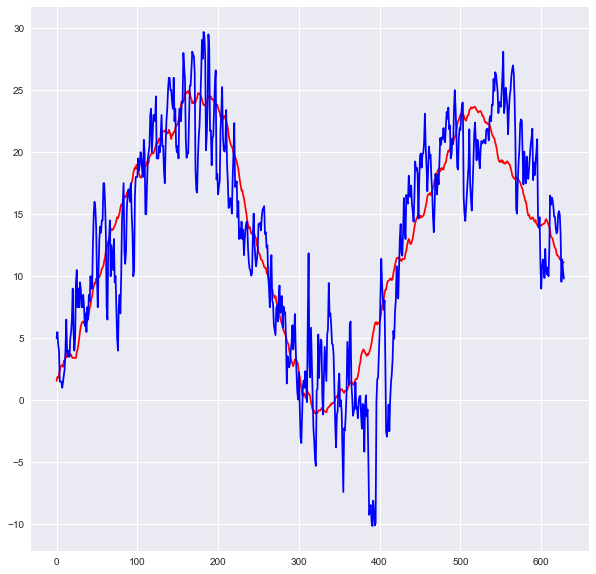

In [3]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_output=1, nb_filter=4):
    model = Sequential()
    model.add(Conv1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', 
                           input_shape=(window_size, nb_input_series, )))
    model.add(MaxPooling1D()) 
    model.add(Conv1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'))
    model.add(MaxPooling1D()) 
    model.add(Flatten())  
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  
    return model



def make_timeseries_innstance(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0], "Out of range"
  
    X = np.atleast_3d(np.array([timeseries[start:start+window_size] for start in range(0,timeseries.shape[0]-window_size)]))
    print("X shape: " + str(X.shape))
    assert len(X.shape) == 3, "Dimension error"
    Y = timeseries[window_size:]
    print("y shape: " + str(Y.shape))

    return X, Y



def eval_timeseries(timeseries, window_length):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0]==1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
  
    model=make_1d_convnet(window_size=window_size, 
                        filter_length=filter_length, 
                        nb_input_series=nb_series,
                        nb_filter=nb_filter)
  
    print(model.summary())
    X, Y = make_timeseries_innstance(timeseries, window_size)
  
    test_size = int(nb_samples*(1-test_split))
    valid_size = int(nb_samples*(1-valid_split-test_split))
  
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
  
    #standardize every 'series' in the input in a loop
    scalers = list()
    print(X_train[:,:,0].shape)
    for i in range(0,X_train.shape[2]):   
        scaler = preprocessing.StandardScaler().fit(X_train[:,:,i])
        scalers.append(scaler)
        X_train[:,:,i] = scaler.transform(X_train[:,:,i])
        X_valid[:,:,i] = scaler.transform(X_valid[:,:,i])
        X_test[:,:,i]  = scaler.transform(X_test[:,:,i])
        
    # setting up callbacks
    patience=40
    early_stopping=EarlyStopping(patience=patience, verbose=1)
    checkpointer=ModelCheckpoint(filepath='weights_1dcnn_temp.hdf5', save_best_only=True, verbose=1)
  
    network_history=model.fit(X_train, Y_train, epochs=50, validation_data=[X_valid,Y_valid],
              verbose=2,
              callbacks=[checkpointer, early_stopping])
    # loading the best model
    model = load_model('weights_1dcnn_temp.hdf5')
  
  
    preds = model.predict(X_test)
  
    plt.figure(figsize=(10,10))
    plt.plot(preds, color='r')
    plt.plot(Y_test, color='b')
    #to predict more days
    return model, scalers, network_history


# We learnt the window_size should encompass roughly a period which is a year in this case
window_size=365

valid_split=0.2
# I increased the testing data to have a longer plot
test_split =0.4
x = df.values[:,0]
#eval_timeseries(x, window_size)
model, scalers, network_history = eval_timeseries(x, window_size)

In [26]:
def predict_next_day(last_365_days, scaler, model):
    last_365_days = last_365_days.reshape(1,-1)
    #print("shape of last days is: " + str(last_365_days.shape))
    last_365_days = np.atleast_3d(scaler.transform(last_365_days))

    next_day = model.predict(last_365_days)
    #print("next day is: " + str(next_day))
    return next_day 

def predict_next_n_days(last_365_days, scaler, model, n):
    # Since I couldnt figure out how to make the output of the model a N long vector of predictions, what I did
    # to get the next N days was this:
    # I predict the next N days by reusing the previous prediction, in a loop this gives me N 'next days'
    for i in range(0, n):  
        next_day = predict_next_day(last_365_days, scaler, model)
        #print("next_day: " + str(next_day))
        last_365_days = np.append(last_365_days,next_day)
        #print("last element in arr: " + str(last_365_days[-1]))
        last_365_days = last_365_days[-365:]
        #print("first element and last after cutting: " + str(last_365_days[0]) + ", " + str(last_365_days[-1]))
        #print("shape: " + str(last_365_days.shape))
        #print(last_365_days)
        #print("-----------------------------------")
    # After this loop the last 30 elements of the 'last_365_days' should be the next 30 days
    next_n_days = last_365_days[-n:] 
    return next_n_days


last_365_days = df[-365:].values[:,0]

#print(last_365_days.shape)

#since i only used 1 series there should be only 1 element in scalers:
scaler = scalers[0]

#elements of the array (25th should be 0.): 26th - 1. 1st of nov - 7. 29th of nov - 35 -> need the next 35 days in this case
next_36 = predict_next_n_days(last_365_days,scaler,model,36)
#print(next_35)
october_26 = next_36[1]
november_1 = next_36[7] 
november_29 = next_36[35]
print("/////////////////////////////////////////////////////////////////////")
print("The end predictions are:")
print("temperature on the 26th of October: " + str(october_26))
print("temperature on the 1st of November: " + str(november_1))
print("temperature on the 29th of November: " + str(november_29))
print("/////////////////////////////////////////////////////////////////////")

/////////////////////////////////////////////////////////////////////
The end predictions are:
temperature on the 26th of October: 10.917038917541504
temperature on the 1st of November: 9.587018966674805
temperature on the 29th of November: 3.239339828491211
/////////////////////////////////////////////////////////////////////


C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was conv

When I ran this on the 25th this is these were the predictions:

/////////////////////////////////////////////////////////////////////

The end predictions are:

temperature on the 26th of October: 10.917038917541504

temperature on the 1st of November: 9.587018966674805

temperature on the 29th of November: 3.239339828491211


/////////////////////////////////////////////////////////////////////

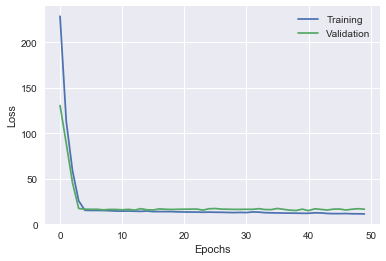

In [27]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

plot_history(network_history)

# LSTM model

I also tried another method before I got anything working with the CNN one based on this article:https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
this approches the problem of prediction with an LSTM network using multiple step prediction.

I felt like this could work for 1-7 days but to use this to predict the temperature next month I thought I'd need to use temperature data averaged for months not days.
This model was more complex then the previous one so I couldn't really add checkpoints or early stopping here, but I left this solution here aswell since I spent a lot of time on it.



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2017-11-09 to 2018-10-24
Data columns (total 4 columns):
t_avg    350 non-null float64
t_max    350 non-null float64
t_min    350 non-null float64
wind     350 non-null float64
dtypes: float64(4)
memory usage: 13.7 KB


C:\Users\Gabor\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.0548
epoch_num: 0
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0540
epoch_num: 1
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0537
epoch_num: 2
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0535
epoch_num: 3
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0535
epoch_num: 4
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0534
epoch_num: 5
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0533
epoch_num: 6
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0533
epoch_num: 7
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0532
epoch_num: 8
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0532
epoch_num: 9
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - los

292/292 [==============================] - 0s 1ms/step - loss: 0.0471
epoch_num: 173
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0469
epoch_num: 174
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0479
epoch_num: 175
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0473
epoch_num: 176
Epoch 1/1
292/292 [==============================] - 0s 997us/step - loss: 0.0489
epoch_num: 177
Epoch 1/1
292/292 [==============================] - 0s 991us/step - loss: 0.0522
epoch_num: 178
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0489
epoch_num: 179
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0490
epoch_num: 180
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0521
epoch_num: 181
Epoch 1/1
292/292 [==============================] - 0s 1ms/step - loss: 0.0503
epoch_num: 182
Epoch 1/1
292/292 [==============================] - 0s 

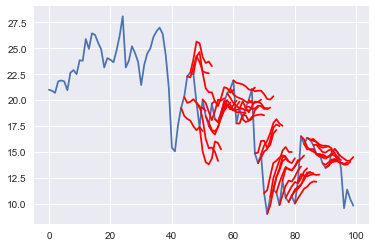

In [15]:

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# this function creates a matrix where each column is shifted by 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# This function creates a differenced series.
# According to the article this is a must if the data has any sort of trend
# I tried out the original example without differencing and the results were
# indeed much worse.
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform the series using the 2 functions above
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    last_prepared = scaled_values[-1]
    #print("last: " + str(last_prepared)) #this is our last value, today's temperature prepared
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test, last_prepared

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    ep_num = 0
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
        print("epoch_num: " + str(ep_num))
        ep_num = ep_num+1
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    series_end = series[-100:]
    pyplot.plot(series_end.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series_end) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series_end.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

# load dataset
df = read_csv('temperature.csv', header=0, parse_dates=[4],index_col=4, squeeze=True)
# I didnt use the whole data set, only about a year's worth
# skip the last entry as by the as that will be used to predict the +1,+7 days
series = df[-350:]
series.info()
#print(series)
# Since I didn't use these columns I got rid of them.
del series['t_max']
del series['t_min']
del series['wind']
last_value = series.values[-1]
# configure
n_lag = 1 
n_seq = 7 
n_test = 50 
n_epochs = 200 
n_batch = 1 
n_neurons = 40 

scaler, train, test, last_prepared = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+(n_seq-1))
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+(n_seq-1))
#print("actual: " + str(actual))
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+(n_seq-1)) # this was originally n_test+2 but that
# only worked for n_seq=3 cases so I had to change it to n_test+(n_seq-1). Later I also found
# other people using this did the same.


In the end i didn't get really good results I think because I didn't tune the network correctly even though I tried many configurations and this last one was the best I could achieve.
This network right now predicts 7 days ahead. The above plot shows the last 50 predictions' plotted onto the original data.


In this last part I basically took the last element of the database (should be the 25th of October if the database was created from the website that day) and use it to predict the next 7 days with the LSTM model from above. For this I saved the already scaled and differenced version to feed it into the model. After this I had to scale back the prediction and use the differences to get the actual numbers in celsius.
I only predicted the next and the next 7th day with this method.

In [16]:
last_prepared = last_prepared.reshape(1, 1, len(last_prepared))
#the last_prepared holds the scaled and differenced value temperature value of the last day
print("last value scaled and differenced:            " + str(last_prepared[0,0]))
print("last_value was (not scaled, not differenced): " + str(last_value))
#this value can be used to predic the next 7 days:
next_7_days = model.predict(last_prepared, batch_size=n_batch)
print("next 7 days (these are still scaled):")
print(next_7_days) #these need to be scaled back and then the difference needs to be reversed

inv_scale = scaler.inverse_transform(next_7_days)
# now we have the differences back, we just have to add up the differences to the last element
# in the database to get the future temperatures
inv_scale = inv_scale[0, :]
print("after scaling them back the differences: " + str(inv_scale))
future_7_forecasts = list()
first = last_value + inv_scale[0]
future_7_forecasts.append(first)
for i in range(1,len(inv_scale)):
    forecast = future_7_forecasts[i-1] + inv_scale[i]
    future_7_forecasts.append(forecast)
    
print(future_7_forecasts)


last value scaled and differenced:            [-0.11764706]
last_value was (not scaled, not differenced): [9.8]
next 7 days (these are still scaled):
[[-0.06214676 -0.0555224  -0.07187118 -0.08644474 -0.04414998 -0.01178276
  -0.02970011]]
after scaling them back the differences: [-0.13107221 -0.06913441 -0.2219955  -0.35825837  0.03719765  0.33983117
  0.17230399]
[array([9.66892779]), array([9.59979338]), array([9.37779787]), array([9.01953951]), array([9.05673716]), array([9.39656833]), array([9.56887232])]


I realized late that on the 25th the last day in the database is the 24th so I only fixed the predictions for the 1d CNN solution, since that was my main solution for the homework. So this prediction is actually for the 25th of October and the 31st of October

In [17]:
#print the +1 and +7 days: (if the database was saved on the 25th these should be the right days)
print("temperature prediction on the 26th of October: " + str(future_7_forecasts[0]))
print("temperature prediction on the 1th of November: " + str(future_7_forecasts[6]))

temperature prediction on the 26th of October: [9.66892779]
temperature prediction on the 1th of November: [9.56887232]


In conclusion I wish I had the time to shape my database into monthly averages and try it again for a 1 month prediction but I simply ran out of time. Still I think I learnt a lot of new things going though these examples and articles mentioned above (Even if my solutions weren't very productive).